In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, precision_score, recall_score, f1_score
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyClassifier

In [115]:
dataset_path = "dataset/dataset-spotify-2023.csv"
data = pd.read_csv(dataset_path, encoding="latin-1")
columns = ["danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%",
"liveness_%", "speechiness_%"]
data = data.rename(columns={column: column.replace("_%", "") for column in columns})
key_None_count = data["key"].isna().sum()
in_shazam_charts_None_count = data["in_shazam_charts"].isna().sum()

print("`key` None count: ", key_None_count)
print("`in_shazam_charts` None count: ", in_shazam_charts_None_count)

# Replace NaN values with Unspecified, it may be useful later on
data = data.replace(np.nan, "Unavailable")

# Data is malformed, need to remove comma `,`
data["in_deezer_playlists"] = data["in_deezer_playlists"].replace(",", "", regex=True)
data["in_shazam_charts"] = data["in_deezer_playlists"].replace(",", "", regex=True)

# Convert columns to int64
# streams, in_deezer_playlists, in_shazam_charts
data["in_deezer_playlists"] = data["in_deezer_playlists"].astype(int)
data["in_shazam_charts"] = data["in_shazam_charts"].astype(int)

# Streams overflowed with int, so use np.int64 to fit the whole numbers
data["streams"] = data["streams"].astype(np.int64)

# Wee see that `streams` is very large compared to to other data, next larger is `in_spotify_playlists`
# Add extra column with log value of streams
# data["streams_log"] = np.log2(data["streams"])

`key` None count:  95
`in_shazam_charts` None count:  50


In [116]:
# One-hot encoding values
data = pd.get_dummies(data, columns=["key", "mode"], prefix=["key", "mode"])
data = data.applymap(lambda x: int(x) if isinstance(x, bool) else x)

In [117]:
# Select numeric columns
data_numeric = data.select_dtypes(exclude="object")
data_numeric.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   artist_count          952 non-null    int64
 1   released_year         952 non-null    int64
 2   released_month        952 non-null    int64
 3   released_day          952 non-null    int64
 4   in_spotify_playlists  952 non-null    int64
 5   in_spotify_charts     952 non-null    int64
 6   streams               952 non-null    int64
 7   in_apple_playlists    952 non-null    int64
 8   in_apple_charts       952 non-null    int64
 9   in_deezer_playlists   952 non-null    int64
 10  in_deezer_charts      952 non-null    int64
 11  in_shazam_charts      952 non-null    int64
 12  bpm                   952 non-null    int64
 13  danceability          952 non-null    int64
 14  valence               952 non-null    int64
 15  energy                952 non-null    int64
 16  acoustic

In [118]:

scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_numeric)
data_numeric = pd.DataFrame(data_normalized, columns=data_numeric.columns)

In [119]:
# Regression
# Target value is `streams`
X = torch.tensor(data_numeric.drop("streams", axis=1).values, dtype=torch.float32)
Y = torch.tensor(data_numeric["streams"].values, dtype=torch.float32).view(-1, 1)

In [120]:
from matplotlib.pyplot import figure, plot, subplot, title, xlabel, ylabel, show
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import torch
import numpy as np

# Selecting features (X) and target variable (y)
composition_features = ['bpm', 'mode_Major', 'mode_Minor', 'key_A',
                        'key_A#',
                        'key_B',
                        'key_C',
                        'key_C#',
                        'key_D',
                        'key_D#',
                        'key_E',
                        'key_F',
                        'key_F#',
                        'key_G',
                        'key_G#', 'danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness',
                        'speechiness']
# musical_features = ['danceability','valence','energy','acousticness','instrumentalness','liveness','speechiness']

X = torch.tensor(
    data_numeric[composition_features].values, dtype=torch.float32)
Y = torch.tensor(data_numeric["streams"].values,
                 dtype=torch.float32).view(-1, 1)

# Crossvalidation
# Create cross-validation partition for evaluation
K = 10
CV = KFold(n_splits=K, shuffle=True, random_state=42)

# Regularization parameter values
lambda_values = [0.001, 0.01, 1, 10, 100,10**3,10**4,10**6,10**8, 10**10]

# Initialize variables
Features = np.zeros((len(composition_features), K, len(lambda_values)))
Error_train = np.empty((K, len(lambda_values)))
Error_test = np.empty((K, len(lambda_values)))

k = 0
for train_index, test_index in CV.split(X):
    # extract training and test set for the current CV fold
    X_train = X[train_index, :]
    y_train = Y[train_index]
    X_test = X[test_index, :]
    y_test = Y[test_index]

    internal_cross_validation = 10

    for i, lambda_val in enumerate(lambda_values):
        # Compute squared error with feature subset selection and Ridge regression
        # Using all features for simplicity
        selected_features = range(X_train.shape[1])
        m = Ridge(alpha=lambda_val, fit_intercept=True).fit(
            X_train[:, selected_features], y_train)
        Error_train[k, i] = np.square(
            y_train - m.predict(X_train[:, selected_features])).sum() / y_train.shape[0]
        Error_test[k, i] = np.square(
            y_test - m.predict(X_test[:, selected_features])).sum() / y_test.shape[0]

    k += 1


sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(lambda_values))

# Display results
print('\n')
for i, lambda_val in enumerate(lambda_values):
    print(f'Ridge Regression with Lambda = {lambda_val}:')
    print('- Training error: {0}'.format(Error_train[:, i].mean()))
    print('- Test error:     {0}'.format(Error_test[:, i].mean()))
    print('\n')

# Plot results
fig, axes = plt.subplots(1, len(lambda_values), figsize=(15, 5), sharey=True)

for i, (lambda_val, ax) in enumerate(zip(lambda_values, axes)):
    sns.lineplot(x=range(
        1, K + 1), y=Error_train[:, i], label='Training Error', ax=ax, color=palette[i])
    sns.lineplot(x=range(
        1, K + 1), y=Error_test[:, i], label='Test Error', ax=ax, color=palette[i], linestyle='dashed')
    ax.set_title(f'Ridge Regression (λ = {lambda_val})')
    ax.set_xlabel('Cross-validation fold')
    ax.set_ylabel('Mean Squared Error')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

KeyError: "['key_C'] not in index"

In [121]:


# Selecting features (X) and target variable (y)
composition_features = ['bpm', 'mode_Major', 'mode_Minor', 'key_A',
 'key_A#',
 'key_B',
 'key_C#',
 'key_D',
 'key_D#',
 'key_E',
 'key_F',
 'key_F#',
 'key_G',
'key_G#', 'danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
#musical_features = ['danceability','valence','energy','acousticness','instrumentalness','liveness','speechiness']

X = torch.tensor(
    data_numeric[composition_features].values, dtype=torch.float32)
Y = torch.tensor(data_numeric["streams"].values,
                 dtype=torch.float32).view(-1, 1)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define a range of values for lambda (regularization parameter)
lambda_values = [0.01, 0.1, 1, 10, 10**8]

# Perform cross-validation for each lambda value
for lambda_val in lambda_values:
    # Creating a Ridge regression model with regularization parameter lambda
    model = Ridge(alpha=lambda_val)

    # Perform 10-fold cross-validation and compute mean squared error for each fold
    cv_scores = cross_val_score(
        model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

    # Calculate the average cross-validation score
    avg_mse = np.mean(-cv_scores)

    print(
        f'Lambda = {lambda_val}, Average Cross-Validation Mean Squared Error: {avg_mse}')

    # Train the model on the entire training set
    model.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluating the model on the test set
    test_mse = mean_squared_error(y_test, y_pred)
    print(f'Test Mean Squared Error: {test_mse}\n')
    print('Composition Features Model')
    print('Coefficients:', model.coef_)
    print('Intercept:', model.intercept_)
    print('\n')

Lambda = 0.01, Average Cross-Validation Mean Squared Error: 1.0805057961249909
Test Mean Squared Error: 0.7729098747591358

Composition Features Model
Coefficients: [[-0.00260807  0.00142666 -0.00142666 -0.04600003  0.02953325 -0.01111807
   0.07326189  0.02920395  0.02742444 -0.00265864 -0.01687531 -0.00251657
  -0.02157316 -0.00115501 -0.11126109  0.04990231 -0.03023924 -0.04485179
  -0.04963613 -0.07926353 -0.13000723]]
Intercept: [0.0162504]


Lambda = 0.1, Average Cross-Validation Mean Squared Error: 1.080493971576956
Test Mean Squared Error: 0.7729028494069827

Composition Features Model
Coefficients: [[-0.0026059   0.00142779 -0.00142779 -0.04600061  0.02952382 -0.01112501
   0.07324291  0.02919338  0.02741606 -0.00266667 -0.01688052 -0.00252344
  -0.0215781  -0.00116214 -0.11123815  0.04988156 -0.03022259 -0.04483382
  -0.04963068 -0.07925295 -0.12999157]]
Intercept: [0.01625051]


Lambda = 1, Average Cross-Validation Mean Squared Error: 1.0803763996184583
Test Mean Squared Err

In [122]:

class LinearRegression(nn.Module):
    def __init__(self, input_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

input_size = X.shape[1] 
model = LinearRegression(input_size=input_size)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 1000
max_gradient_norm = 5.0

for epoch in range(num_epochs):
    outputs = model(X)
    loss = criterion(outputs, Y)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_gradient_norm)
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

predicted = model(X).detach().numpy()

Epoch [100/1000], Loss: 0.9669
Epoch [200/1000], Loss: 0.9601
Epoch [300/1000], Loss: 0.9592
Epoch [400/1000], Loss: 0.9589
Epoch [500/1000], Loss: 0.9587
Epoch [600/1000], Loss: 0.9585
Epoch [700/1000], Loss: 0.9585
Epoch [800/1000], Loss: 0.9584
Epoch [900/1000], Loss: 0.9584
Epoch [1000/1000], Loss: 0.9584


In [123]:
# Classification

# Classify songs based on chart performance, `hit` songs on specific threshold
# Let's define the `hit` threshold
# Percentile analysis
# You could define a hit as songs that fall within the top 10% of stream counts in your dataset.
threshold = np.percentile(data["streams"], 80)
data_numeric["hit"] = (data_numeric["streams"] >= threshold).astype(int)

# Note:
# Lyrical Content (this requires scrapping)

In [124]:
# Classification - Baseline

# Classify songs based on chart performance, `hit` songs on specific threshold
# Let's define the `hit` threshold
# Percentile analysis
# You could define a hit as songs that fall within the top 10% of stream counts in your dataset.
hit_threshold = data_numeric["streams"].quantile(0.9)

data_numeric['hit'] = data_numeric['streams'] >= hit_threshold


bl_X = data_numeric[composition_features]
bl_y = data_numeric['hit']

# Split the dataset into training and testing sets
bl_X_train, bl_X_test, bl_y_train, bl_y_test = train_test_split(
    bl_X, bl_y, test_size=0.2, random_state=42)

# Create a Dummy Classifier as the baseline
baseline_model = DummyClassifier(strategy='most_frequent')

# Train the baseline model
baseline_model.fit(bl_X_train, bl_y_train)

# Make predictions
baseline_predictions = baseline_model.predict(bl_X_test)

# Evaluate the baseline model
accuracy = accuracy_score(bl_y_test, baseline_predictions)
precision = precision_score(bl_y_test, baseline_predictions, zero_division=1)
recall = recall_score(bl_y_test, baseline_predictions)
f1 = f1_score(bl_y_test, baseline_predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9267
Precision: 1.0000
Recall: 0.0000
F1 Score: 0.0000


In [125]:
# No this doesn't make sense

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=cv, scoring="accuracy")

print("Cross-Validation Scores:", cv_scores)
print(f"Average Cross-Validation Accuracy: {cv_scores.mean():.2f}")

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Test Set Accuracy: {accuracy:.2f}")

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Average Cross-Validation Accuracy: 1.00
Test Set Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191

    accuracy                           1.00       191
   macro avg       1.00      1.00      1.00       191
weighted avg       1.00      1.00      1.00       191



-----------------------------------------------------#HENI CODE- ----------------------------------------------

In [129]:
data['populartity'] = data['streams'].apply(lambda x: 1 if x > threshold else 0)
myClassNames = ['Not Popular', 'Popular']
y = data['populartity']
X = data[composition_features]
X.head()

,bpm,mode_Major,mode_Minor,key_A,key_A#,key_B,key_C#,key_D,key_D#,key_E,...,key_F#,key_G,key_G#,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness
0,125,1,0,0,0,1,0,0,0,0,...,0,0,0,80,89,83,31,0,8,4
1,92,1,0,0,0,0,1,0,0,0,...,0,0,0,71,61,74,7,0,10,4
2,138,1,0,0,0,0,0,0,0,0,...,0,0,0,51,32,53,17,0,31,6
3,170,1,0,1,0,0,0,0,0,0,...,0,0,0,55,58,72,11,0,11,15
4,144,0,1,1,0,0,0,0,0,0,...,0,0,0,65,23,80,14,63,11,6


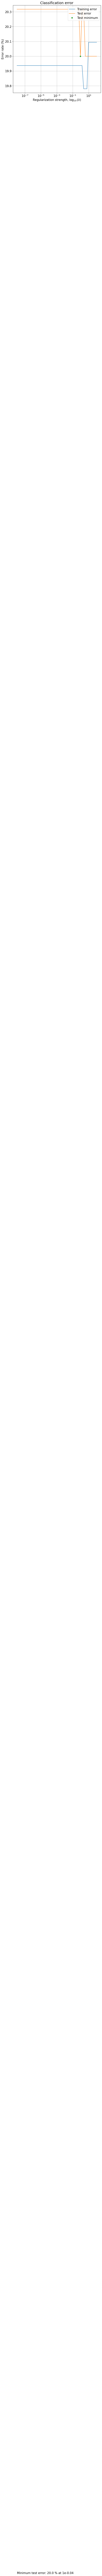

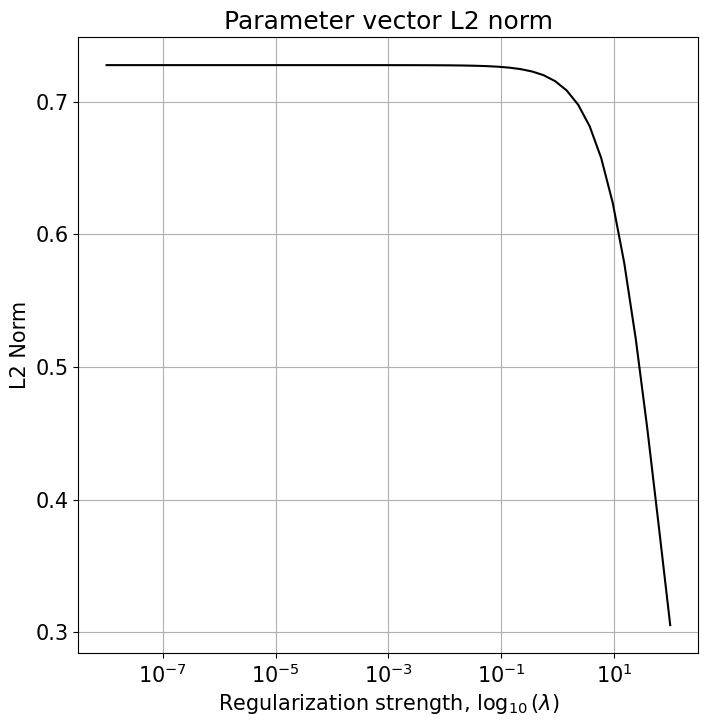

Ran Exercise 9.1.1


In [132]:
scaler = StandardScaler()

# Create crossvalidation partition for evaluation
K = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, stratify=y)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Fit regularized logistic regression model to training data to predict 
# the type of wine
lambda_interval = np.logspace(-8, 2, 50)
train_error_rate = np.zeros(len(lambda_interval))
test_error_rate = np.zeros(len(lambda_interval))
coefficient_norm = np.zeros(len(lambda_interval))
for k in range(0, len(lambda_interval)):
    mdl = LogisticRegression(penalty='l2', C = 1/lambda_interval[k] )
    
    mdl.fit(X_train, y_train)

    y_train_est = mdl.predict(X_train)
    y_test_est = mdl.predict(X_test)
    
    train_error_rate[k] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[k] = np.sum(y_test_est != y_test) / len(y_test)

    w_est = mdl.coef_[0] 
    coefficient_norm[k] = np.sqrt(np.sum(w_est**2))

min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambda_interval[opt_lambda_idx]

plt.figure(figsize=(8,8))
#plt.plot(np.log10(lambda_interval), train_error_rate*100)
#plt.plot(np.log10(lambda_interval), test_error_rate*100)
#plt.plot(np.log10(opt_lambda), min_error*100, 'o')
plt.semilogx(lambda_interval, train_error_rate*100)
plt.semilogx(lambda_interval, test_error_rate*100)
plt.semilogx(opt_lambda, min_error*100, 'o')
plt.text(1e-8, 3, "Minimum test error: " + str(np.round(min_error*100,2)) + ' % at 1e' + str(np.round(np.log10(opt_lambda),2)))
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.ylabel('Error rate (%)')
plt.title('Classification error')
plt.legend(['Training error','Test error','Test minimum'],loc='upper right')
plt.grid()
plt.show()    

plt.figure(figsize=(8,8))
plt.semilogx(lambda_interval, coefficient_norm,'k')
plt.ylabel('L2 Norm')
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.title('Parameter vector L2 norm')
plt.grid()
plt.show()    